In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import gc
import lightgbm as lgb
from sklearn.metrics import precision_score, recall_score, roc_auc_score
import matplotlib.pyplot as plt
from itertools import combinations
from sklearn.model_selection import train_test_split
import pickle
from multiprocessing import Pool
from tqdm import tqdm

# Prepare data

* Attributed rate: how attribution is distributed in combinations
* Click counts: how clicks are distributed in combinations
* Rolling click counts: how clicks are distributed in combinations in sliding windows

In [2]:
hdf_path = '../derived_data/source.hdf'

In [3]:
res_hdf_path = '../derived_data/feats_pile.hdf'

In [4]:
%%time
dat = pd.read_hdf(hdf_path, key='train')

CPU times: user 492 ms, sys: 8.2 s, total: 8.69 s
Wall time: 38.9 s


In [5]:
dat.head()

,ip,app,device,os,channel,click_time,is_attributed
0,83230,3,1,13,379,2017-11-06 14:32:21,0
1,17357,3,1,19,379,2017-11-06 14:33:34,0
2,35810,3,1,13,379,2017-11-06 14:34:12,0
3,45745,14,1,13,478,2017-11-06 14:34:52,0
4,161007,3,1,13,379,2017-11-06 14:35:08,0


In [6]:
train = dat.loc[(dat.click_time >= '2017-11-08 04:00:00') & (dat.click_time < '2017-11-08 15:00:00')].copy()

In [7]:
valid = dat.loc[(dat.click_time >= '2017-11-09 04:00:00') & (dat.click_time < '2017-11-09 15:00:00')].copy()

In [8]:
del dat

In [9]:
gc.collect()

24

In [10]:
most_freq_hours_in_test_data = [4, 5, 9, 10, 13, 14]
least_freq_hours_in_test_data = [6, 11, 15]

In [11]:
feats2comb = ['ip', 'app', 'device', 'os', 'channel']

In [12]:
def get_all_comb_feats(feats2comb, n=None):
    if n is None:
        n = len(feats2comb)
    res = []
    for i in range(n):
        for comb_feats in combinations(feats2comb, i+1):
            res.append(list(comb_feats))
    return res

In [13]:
uint8_max = np.iinfo(np.uint8).max
uint16_max = np.iinfo(np.uint16).max
uint32_max = np.iinfo(np.uint32).max
def choose_int_type(n):
    if n <= uint8_max:
        return 'uint8'
    elif n <= uint16_max:
        return 'uint16'
    elif n <= uint32_max:
        return 'uint32'
    else:
        return 'uint64'

In [14]:
def get_label_count(args):
    gp = args[0].groupby(args[1], sort=False).size()
    gp = gp.astype(choose_int_type(gp.max()))
    gp = gp.to_frame().rename(columns={0: 'n_' + '_'.join(args[1]) + '_count'})
    gc.collect()
    return gp

In [15]:
def rolling_count(df, time_win='30min'):
    return df.groupby('click_time', sort=False).size().rolling(time_win).sum()

In [16]:
def get_label_rolling_count(args):
    gp = args[0].groupby(args[1], sort=False).apply(rolling_count, time_win='30min')
    gp = gp.astype(choose_int_type(gp.max()))
    gp = gp.to_frame().rename(columns={0: 'n_' + '_'.join(args[1]) + '_rolling_count'})
    gc.collect()
    return gp

In [17]:
def get_labels(function, all_comb_feats):
    print(pd.datetime.now())
    aggs = []
    with Pool(processes=4) as pool:
        for dist in pool.imap_unordered(function, all_comb_feats):
            aggs.append(dist.copy())
            gc.collect()
    return aggs

In [18]:
def merge(df, dists):
    for dist in tqdm(dists):
        df = df.merge(dist, left_on=dist.index.names, right_index=True, how='left')
    return df

In [19]:
gc.collect()

0

In [20]:
all_comb_feats = get_all_comb_feats(feats2comb, 5)

In [21]:
len(all_comb_feats)

31

In [21]:
train_all_comb_feats =[(train, ['day_section'] + comb_feat) for comb_feat in all_comb_feats]
                  # [['hour'] + comb_feat for comb_feat in all_comb_feats] +
                  # [['minute'] + comb_feat for comb_feat in all_comb_feats] +
                  # [['day_section'] + comb_feat for comb_feat in all_comb_feats] +
                  # [['in_test_hh', 'day_section'] + comb_feat for comb_feat in all_comb_feats])

In [22]:
valid_all_comb_feats =[(valid, ['day_section'] + comb_feat) for comb_feat in all_comb_feats]

In [23]:
def process(df, all_comb_feats):
    print('Adding hour...')
    df.loc[:, 'hour'] = df.click_time.dt.hour.astype('uint8')
    print('Adding minute...')
    df.loc[:, 'minute'] = df.hour.astype('uint16') * 60 + df.click_time.dt.minute.astype('uint16')
    print('Adding in_test_hh')
    df.loc[:, 'in_test_hh'] = (
        3 - 2*df.hour.isin(most_freq_hours_in_test_data) -
        1*df.hour.isin(least_freq_hours_in_test_data)
    ).astype('uint8')
    print('Adding day_section...')
    df.loc[:, 'day_section'] = (df.hour // 6).astype('uint8')
    print('Getting counts...')
    df_counts = get_labels(get_label_count, all_comb_feats)
    print('Merging...')
    df = merge(df, df_counts)
    gc.collect()
    return df

In [24]:
%%time
train = process(train, train_all_comb_feats)

Adding hour...
Adding minute...
Adding in_test_hh
Adding day_section...
Getting counts...
2018-04-17 19:42:58.589329


  0%|          | 0/31 [00:00<?, ?it/s]

Merging...


100%|██████████| 31/31 [03:30<00:00,  6.80s/it]

CPU times: user 3min 39s, sys: 2min 7s, total: 5min 46s
Wall time: 5min 9s


In [25]:
%%time
valid = process(valid, valid_all_comb_feats)

Adding hour...
Adding minute...
Adding in_test_hh
Adding day_section...
Getting counts...
2018-04-17 19:48:07.767873


  0%|          | 0/31 [00:00<?, ?it/s]

Merging...


100%|██████████| 31/31 [03:35<00:00,  6.95s/it]

CPU times: user 3min 44s, sys: 2min 11s, total: 5min 55s
Wall time: 5min 18s


In [26]:
key = 'day_section'

In [27]:
%%time
train.to_hdf(res_hdf_path, key=key+'_train', model='r+')

CPU times: user 6.97 s, sys: 7.29 s, total: 14.3 s
Wall time: 25.6 s


In [28]:
%%time
valid.to_hdf(res_hdf_path, key=key+'_valid', model='r+')

CPU times: user 6.62 s, sys: 8.84 s, total: 15.5 s
Wall time: 37.6 s


In [29]:
gc.collect()

0

In [10]:
train = pd.read_hdf(res_hdf_path, key=key+'_train')

In [11]:
valid = pd.read_hdf(res_hdf_path, key=key+'_valid')

# Split for training

In [30]:
gc.collect()

0

In [31]:
train.drop(['ip', 'click_time'], axis=1, inplace=True)

In [32]:
valid.drop(['ip', 'click_time'], axis=1, inplace=True)

In [33]:
gc.collect()

14

In [34]:
_, valid = train_test_split(valid, test_size=0.2, stratify=valid.is_attributed)

In [35]:
train.shape

(36475438, 40)

In [36]:
train.is_attributed.value_counts(normalize=True)

0    0.997421
1    0.002579
Name: is_attributed, dtype: float64

In [37]:
valid.shape

(7433836, 40)

In [38]:
valid.is_attributed.value_counts(normalize=True)

0    0.997415
1    0.002585
Name: is_attributed, dtype: float64

# Light GBM

In [39]:
train.columns

Index(['app', 'device', 'os', 'channel', 'is_attributed', 'hour', 'minute',
       'in_test_hh', 'day_section', 'n_day_section_ip_count',
       'n_day_section_app_count', 'n_day_section_device_count',
       'n_day_section_os_count', 'n_day_section_channel_count',
       'n_day_section_ip_app_count', 'n_day_section_ip_device_count',
       'n_day_section_ip_os_count', 'n_day_section_app_device_count',
       'n_day_section_app_os_count', 'n_day_section_ip_channel_count',
       'n_day_section_app_channel_count', 'n_day_section_device_os_count',
       'n_day_section_device_channel_count', 'n_day_section_os_channel_count',
       'n_day_section_ip_app_device_count', 'n_day_section_ip_app_os_count',
       'n_day_section_ip_device_os_count',
       'n_day_section_ip_app_channel_count',
       'n_day_section_ip_device_channel_count',
       'n_day_section_app_device_os_count',
       'n_day_section_app_device_channel_count',
       'n_day_section_app_os_channel_count',
       'n_day_sect

In [40]:
target = 'is_attributed'

In [41]:
predictors = train.columns.tolist()

In [42]:
predictors.remove(target)

In [43]:
predictors

['app',
 'device',
 'os',
 'channel',
 'hour',
 'minute',
 'in_test_hh',
 'day_section',
 'n_day_section_ip_count',
 'n_day_section_app_count',
 'n_day_section_device_count',
 'n_day_section_os_count',
 'n_day_section_channel_count',
 'n_day_section_ip_app_count',
 'n_day_section_ip_device_count',
 'n_day_section_ip_os_count',
 'n_day_section_app_device_count',
 'n_day_section_app_os_count',
 'n_day_section_ip_channel_count',
 'n_day_section_app_channel_count',
 'n_day_section_device_os_count',
 'n_day_section_device_channel_count',
 'n_day_section_os_channel_count',
 'n_day_section_ip_app_device_count',
 'n_day_section_ip_app_os_count',
 'n_day_section_ip_device_os_count',
 'n_day_section_ip_app_channel_count',
 'n_day_section_ip_device_channel_count',
 'n_day_section_app_device_os_count',
 'n_day_section_app_device_channel_count',
 'n_day_section_app_os_channel_count',
 'n_day_section_ip_os_channel_count',
 'n_day_section_device_os_channel_count',
 'n_day_section_ip_app_device_os_cou

In [44]:
categorical = ['app', 'device', 'os', 'channel', 'hour', 'minute', 'in_test_hh', 'day_section']

In [45]:
gc.collect()

20

In [46]:
params = {
    'boosting_type': 'dart',  # I think dart would be better, but takes too long to run
    'drop_rate': 0.1,  # Rate at which to drop trees
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.1,
    'num_leaves': 10,  # Was 255: Reduced to control overfitting
    'max_depth': 9,  # Was 8: LightGBM splits leaf-wise, so control depth via num_leaves
    'min_child_samples': 10,
    'max_bin': 100,
    'subsample': 0.7,  # Was 0.7
    'subsample_freq': 1,
    'colsample_bytree': 0.7,
    'min_child_weight': 0,
    'subsample_for_bin': 200000,
    'min_split_gain': 0,
    'reg_alpha': 0,
    'reg_lambda': 0,
    'nthread': 8,
    'verbose': 0,
    'scale_pos_weight': 200
}

In [47]:
dtrain = lgb.Dataset(
    train.loc[:, predictors],
    label=train.loc[:, target],
    feature_name=predictors,
    categorical_feature=categorical
)

dvalid = lgb.Dataset(
    valid.loc[:, predictors],
    label=valid.loc[:, target],
    feature_name=predictors,
    categorical_feature=categorical
)

In [48]:
del train

In [49]:
del valid

In [50]:
gc.collect()

39

In [51]:
%%time
evals_results = {}
lgb_model = lgb.train(
    params, 
    dtrain, 
    valid_sets= [dtrain, dvalid], 
    valid_names=['train', 'valid'], 
    evals_result=evals_results, 
    num_boost_round=1000,
    early_stopping_rounds=50,
    verbose_eval=10, 
    feval=None
)

/home/fei/miniconda3/envs/kaggle_ml/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/fei/miniconda3/envs/kaggle_ml/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overrided.
  warnings.warn('categorical_feature in param dict is overrided.')


Training until validation scores don't improve for 50 rounds.
[10]	train's auc: 0.966767	valid's auc: 0.957899
[20]	train's auc: 0.971762	valid's auc: 0.962025
[30]	train's auc: 0.972807	valid's auc: 0.963736
[40]	train's auc: 0.974322	valid's auc: 0.965431
[50]	train's auc: 0.974819	valid's auc: 0.966004
[60]	train's auc: 0.975301	valid's auc: 0.966282
[70]	train's auc: 0.97555	valid's auc: 0.966541
[80]	train's auc: 0.975902	valid's auc: 0.966706
[90]	train's auc: 0.976127	valid's auc: 0.966816
[100]	train's auc: 0.976276	valid's auc: 0.966925
[110]	train's auc: 0.976329	valid's auc: 0.967099
[120]	train's auc: 0.976702	valid's auc: 0.967436
[130]	train's auc: 0.976974	valid's auc: 0.967741
[140]	train's auc: 0.977293	valid's auc: 0.96777
[150]	train's auc: 0.977439	valid's auc: 0.96792
[160]	train's auc: 0.977457	valid's auc: 0.96795
[170]	train's auc: 0.977786	valid's auc: 0.968133
[180]	train's auc: 0.978329	valid's auc: 0.968309
[190]	train's auc: 0.978928	valid's auc: 0.968656
[

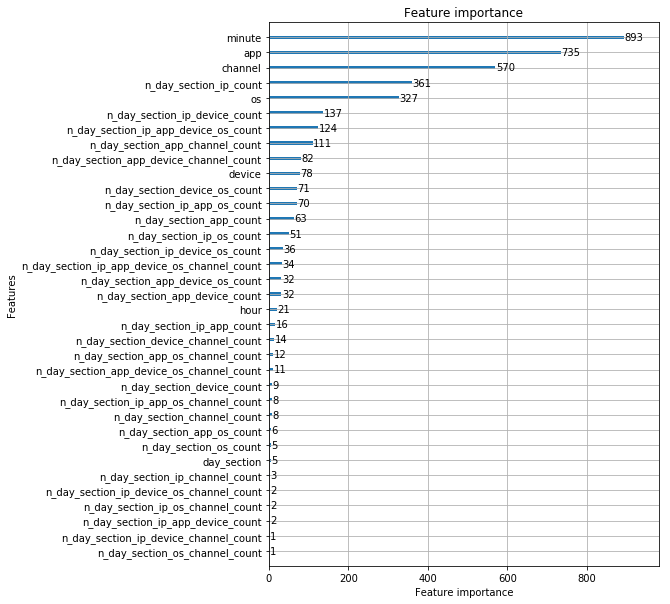

In [52]:
f, ax = plt.subplots(figsize=[7,10])
lgb.plot_importance(lgb_model, ax=ax, max_num_features=len(predictors))

In [53]:
import pickle

In [54]:
with open('../results/in_test_hh.pickle', 'wb') as f:
    pickle.dump(lgb_model, f)

In [34]:
with open('../results/rolling_window.pickle', 'rb') as f:
    lgb_model = pickle.load(f)

# Create submission

In [55]:
test = pd.read_hdf(hdf_path, key='test')

In [56]:
test.head()

,click_id,ip,app,device,os,channel,click_time
0,0,5744,9,1,3,107,2017-11-10 04:00:00
1,1,119901,9,1,3,466,2017-11-10 04:00:00
2,2,72287,21,1,19,128,2017-11-10 04:00:00
3,3,78477,15,1,13,111,2017-11-10 04:00:00
4,4,123080,12,1,13,328,2017-11-10 04:00:00


In [57]:
test_all_comb_feats =[(test, ['day_section'] + comb_feat) for comb_feat in all_comb_feats]

In [58]:
test = process(test, test_all_comb_feats)

Adding hour...
Adding minute...
Adding in_test_hh
Adding day_section...
Getting counts...
2018-04-17 21:45:23.228751


  0%|          | 0/31 [00:00<?, ?it/s]

Merging...


100%|██████████| 31/31 [01:41<00:00,  3.28s/it]


In [59]:
test.head()

,click_id,ip,app,device,os,channel,click_time,hour,minute,in_test_hh,...,n_day_section_app_device_channel_count,n_day_section_app_os_channel_count,n_day_section_ip_os_channel_count,n_day_section_device_os_channel_count,n_day_section_ip_app_device_os_count,n_day_section_ip_app_device_channel_count,n_day_section_app_device_os_channel_count,n_day_section_ip_app_os_channel_count,n_day_section_ip_device_os_channel_count,n_day_section_ip_app_device_os_channel_count
0,0,5744,9,1,3,107,2017-11-10 04:00:00,4,240,1,...,82205,2217,1,10745,1,4,2156,1,1,1
1,1,119901,9,1,3,466,2017-11-10 04:00:00,4,240,1,...,125848,2122,1,2335,4,15,2037,1,1,1
2,2,72287,21,1,19,128,2017-11-10 04:00:00,4,240,1,...,71938,21237,10,37558,11,13,20029,6,10,6
3,3,78477,15,1,13,111,2017-11-10 04:00:00,4,240,1,...,25603,5437,2,5421,14,2,5421,2,2,2
4,4,123080,12,1,13,328,2017-11-10 04:00:00,4,240,1,...,69847,15945,2,15902,5,2,15902,2,2,2


In [60]:
pred = lgb_model.predict(test.loc[:, predictors], num_iteration=lgb_model.best_iteration)

In [61]:
test.loc[:, 'is_attributed'] = pred

In [62]:
test.loc[:, ['click_id', 'is_attributed']].to_csv('../results/day_section.csv', index=False)

In [63]:
test.loc[:, ['click_id', 'is_attributed']].head()

,click_id,is_attributed
0,0,0.111513
1,1,0.060055
2,2,0.012854
3,3,0.022093
4,4,0.035084
